This notebook has the following additions to the `nn-from-scratch` notebook
- various different types of initialization (Xavier, He).
- dropout.
- GD with momentum and Adam.
- Use of random mini-batches to accelerate convergence and improve optimization.
- Learning rate decay.

# Importing Libraries

In [1]:
# for classes
import numpy as np
# for generating synthetic datasets
from sklearn.datasets import make_classification, make_regression
from sklearn.preprocessing import OneHotEncoder, StandardScaler
# for plotting
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# Defining the Classes

The first class we define is the `layer` class. It contains the main functions and data that we would associate a layer to have.
It is advantageous to use classes since they provide a convenient way to bundle up associated functions and variables.

In [2]:
class layer():
    '''
    Class implementing a neural network layer.

    #############################################################################################################################
    
    INPUTS

    __init__
    
        n_units : number of units in layer.
        input_shape : shape of input. (num_units_in_prev_layer, num_examples) format.
        activation : the activation function to use (tanh, linear, softmax and relu supported).
        learning_rate: learning rate for gradient descent.

    forward_pass 

        A_in : The input activations to the neural network layer.

    backward_pass

        dJ_dA_out : The gradient of the cost, J, with respect to the output activation of the layer, A_out. 
                    This is computed either by seeding (at the last layer), or is passed from the next layer, during backprop.

    #############################################################################################################################
    
    FUNCTIONS

    __init__ (required by Python)
    
    init_parameters : initialize the parameters W, b for the layer. W is initialized to small random numbers while b is initialized to zeros.
    
    forward_pass : implements the forward pass through the layer.
    
    backward_pass : implements the backward pass through the layer, computing the associated gradients.
    
    update_parameters : implements one step of Gradient Descent, updating W, b.
    
    #############################################################################################################################
    
    OUTPUTS

    forward_pass : Returns A_out, the activation of the (current) layer.
    
    backward_pass: Returns dJ_dA_in, the gradient of the cost (J) with respect to the activation input to the layer during forward prop, A_in.
    
    #############################################################################################################################
    
    '''
    def __init__(self, n_units, input_shape, activation, learning_rate, initialization='he', dropout=True, drop_prob=0.0, optimizer = 'gd'):
        
        self.n_units = n_units
        self.input_shape = input_shape
        self.activation = activation
        self.learning_rate = learning_rate
        self.initialization = initialization
        self.dropout = dropout
        self.drop_prob = drop_prob
        self.optim = optimizer
        
    def init_parameters(self):
        '''
        Initialize W, b
        '''
        if self.initialization == 'random':
            
            W = np.random.randn(self.n_units, self.input_shape[0])*0.001
            b = np.random.randn(self.n_units, 1)*0.001
            
        elif self.initialization == 'he':
            
            W = np.random.normal(0, np.sqrt(2/self.input_shape[0]),
                                 size=(self.n_units, self.input_shape[0]))
            b = np.random.normal(0, np.sqrt(2/self.input_shape[0]),
                                 size=(self.n_units, 1))
            
        elif self.initialization == 'xavier':
            
            W = np.random.normal(0, np.sqrt(2/(self.n_units+self.input_shape[0])),
                                 size=(self.n_units, self.input_shape[0]))
            b = np.random.normal(0, np.sqrt(2/(self.n_units+self.input_shape[0])),
                                 size=(self.n_units, 1))
        else:
            raise ValueError("initialization type is not implemented! Try 'random','he',or 'xavier' ")

        # initialize the moving averages for GD with momentum.
        if self.optim == 'gd_m':
            self.v_dJ_dW = np.zeros(W.shape)
            self.v_dJ_db = np.zeros(b.shape)

        if self.optim == 'adam':
            self.v_dJ_dW = np.zeros(W.shape)
            self.v_dJ_db = np.zeros(b.shape)
            self.s_dJ_dW = np.zeros(W.shape)
            self.s_dJ_db = np.zeros(b.shape)
            self.eps = 1e-8
            # counter to count timesteps
            self.timestep_counter = 0
            
        self.W = W
        self.b = b

    def forward_pass(self, A_in):
        Z = np.dot(self.W, A_in) + self.b
        if (self.activation == 'linear'):
            A = Z
        elif (self.activation == 'relu'):
            A = np.maximum(0, Z)
        elif (self.activation == 'sigmoid'):
            A = 1.0/(1.0 + np.exp(-Z))
        elif (self.activation == 'tanh'):
            A = np.tanh(Z)
        elif (self.activation == 'softmax'):
            A = np.exp(Z)/np.sum(np.exp(Z), axis=0)
        else:
            raise ValueError("activation is not implemented!")
        if self.dropout == True:
            self.dropout_mask = (np.random.rand(*A.shape) > self.drop_prob)/(1.0 - self.drop_prob)
            A = A * self.dropout_mask
        elif self.dropout == False:
            self.dropout_mask = np.ones(A.shape)
            A = A * self.dropout_mask
        else:
            raise ValueError("`dropout` recieved invalid value.")
        
        self.Z = Z
        self.A_in = A_in
        self.A_out = A
        
        return A

    def backward_pass(self, dJ_dA_out0):

        dJ_dA_out = dJ_dA_out0*self.dropout_mask
        
        if (self.activation == 'linear'):
            dJ_dZ = dJ_dA_out
        elif (self.activation == 'relu'):
            dJ_dZ = dJ_dA_out * (self.Z > 0).astype(np.float64)
        elif (self.activation == 'sigmoid'):
            dJ_dZ = dJ_dA_out * self.A_out * (1 - self.A_out)
        elif (self.activation == 'tanh'):
            dJ_dZ = dJ_dA_out * (1 - (self.A_out * self.A_out))
        elif (self.activation == 'softmax'): 
            dJ_dZ = self.A_out * (dJ_dA_out - np.sum(dJ_dA_out * self.A_out, axis=0, keepdims=True))
        else:
            raise ValueError("activation is not implemented!")

        self.dJ_dW = np.dot(dJ_dZ, self.A_in.T)
        self.dJ_db = np.sum(dJ_dZ, axis=1, keepdims=True)
        dJ_dA_in = np.dot(self.W.T, dJ_dZ)

        return dJ_dA_in

    def update_parameters(self):
        if self.optim == 'gd': # Gradient Descent
            self.W = self.W - self.learning_rate * self.dJ_dW
            self.b = self.b - self.learning_rate * self.dJ_db
        elif self.optim == 'gd_m': # Gradient Descent with Momentum
            # default choice, generally works well and does not need tuning.
            self.beta = 0.9 
            self.v_dJ_dW = self.beta*self.v_dJ_dW + (1-self.beta)*self.dJ_dW
            self.v_dJ_db = self.beta*self.v_dJ_db + (1-self.beta)*self.dJ_db
            self.W = self.W - self.learning_rate*self.v_dJ_dW
            self.b = self.b - self.learning_rate*self.v_dJ_db
        elif self.optim == 'adam': # Adam Optimizer
            # default choice that works well, and isn't usually tuned.
            self.beta1 = 0.9
            self.beta2 = 0.999
            self.timestep_counter += 1
            self.v_dJ_dW = self.beta1*self.v_dJ_dW + (1-self.beta1)*self.dJ_dW
            self.v_dJ_db = self.beta1*self.v_dJ_db + (1-self.beta1)*self.dJ_db
            self.s_dJ_dW = self.beta2*self.s_dJ_dW + (1-self.beta2)*(self.dJ_dW**2.0)
            self.s_dJ_db = self.beta2*self.s_dJ_db + (1-self.beta2)*(self.dJ_db**2.0)
            self.v_dJ_dW_hat = self.v_dJ_dW/(1 - self.beta1**self.timestep_counter)
            self.v_dJ_db_hat = self.v_dJ_db/(1 - self.beta1**self.timestep_counter)
            self.s_dJ_dW_hat = self.s_dJ_dW/(1 - self.beta2**self.timestep_counter)
            self.s_dJ_db_hat = self.s_dJ_db/(1 - self.beta2**self.timestep_counter)
            self.W = self.W - self.learning_rate*self.v_dJ_dW_hat/(np.sqrt(self.s_dJ_dW_hat)+self.eps)
            self.b = self.b - self.learning_rate*self.v_dJ_db_hat/(np.sqrt(self.s_dJ_db_hat)+self.eps)
        else:
            raise ValueError("`optimizer` did not recieve valid choice.")


In [3]:
class multiclass_classifier_nn():
    '''
    Class implementing a simple multi-class classifier using the `layer` class.

    #############################################################################################################################
    
    INPUTS

    __init__
    
        layers : a list containing the number of units in each layer, including the input layer.
        training_iterations : number of iterations to train the NN.
        learning_rate : the learning rate, passed to the component layers.

    train

        X : (n_features, m) matrix.
        Y : (n_classes, m) matrix.
        
        Where m is the number of training examples.

    predict_proba

        X : (n_features, m') matrix.

        Where m' is the number of (validation/test) examples. X here represents the validation/test input data, once the training
        is complete.

    #############################################################################################################################
    
    FUNCTIONS

    __init__ (required by Python)
    
    train : This function implements the following:
        (1) initialize the layers, and store them in a list called self.nn.
        (2) For `training_iterations` iterations, repeat:
        
            - Forward Pass
                For each layer in the NN, pass it the activations of the previous layer (X, the training data, for the first layer)
                and store the activations.
                
            - Compute Cost
                Also store the cost in a list called self.J_hist to be able to draw cost v/s iteration curves.
                
            - Backward Pass
                For each layer in the NN, going in reverse, pass it the gradient of the cost with respect to its activations.
                For the last layer (first in backprop), pass it dJ/dYhat where Yhat is the matrix of predicted values. Also,
                store this list of gradients.

            - Update parameters
                Once backprop is done, go back to each layer and call the update_parameters() function to update the W, b of each
                layer.

    predict_proba : given a (possibly unseen) set `X` (which need **not** be the same as the training set `X` passed to `train`),
                    run forward propagation on the neural network and return the output of the final layer,
                    i.e., Yhat, the prediction of the neural network.
        
    
    
    #############################################################################################################################
    
    OUTPUTS

    train : self.nn, self.J_hist - the list of (trained) layers forming the neural network, as well as the list storing the cost after each
            training iteration.
    
    predict_proba : Return the prediction of the neural network, that is, the activation of the last layer. It is also called Yhat.
    
    #############################################################################################################################
    '''
    
    def __init__(self, layers, training_iterations, learning_rate, initialization='he', dropout=True, drop_prob=0.0, optimizer = 'gd', num_batches=10, decay_rate = 0.1, decay_step=10):        
        self.layers = layers
        self.training_iterations = training_iterations 
        self.learning_rate = learning_rate
        self.initialization = initialization
        self.dropout = dropout
        self.drop_prob = drop_prob
        self.optim = optimizer
        self.num_batches = num_batches
        self.decay_rate = decay_rate # learning rate decay rate
        self.decay_step = decay_step
        
        self.nn = [] # list of layers making up the neural network
        self.J_hist = [] # costs history
    def train(self, X, Y):
        
        assert X.shape[1] == Y.shape[1]
        
        n_features = X.shape[0]
        n_classes = Y.shape[0]
        m = X.shape[1] 

        # initialize the layers.
        for i in range(1, len(self.layers)):
            if (i != len(self.layers) - 1):
                l = layer(n_units = self.layers[i], input_shape=[self.layers[i-1],m], activation='relu', learning_rate = self.learning_rate, initialization=self.initialization,
                         dropout=self.dropout, drop_prob=self.drop_prob, optimizer=self.optim)
                l.init_parameters()
                self.nn.append(l)
            else:
                l = layer(n_units = self.layers[i], input_shape=[self.layers[i-1],m], activation='softmax', learning_rate = self.learning_rate, initialization=self.initialization,
                         dropout=False, drop_prob=0.0, optimizer=self.optim) # last layer - no dropout
                l.init_parameters()
                self.nn.append(l)
        
        assert len(self.nn) == len(self.layers)-1

        
        for n_iter in range(self.training_iterations):
            
            if n_iter % self.decay_step == 0: # every decay_step iterations, reduce the learning rate
                self.learning_rate = self.learning_rate * (1-self.decay_rate)
                for layers in self.nn:
                    layers.learning_rate = self.learning_rate
            J = 0.0
            J_sum = 0.0
            mini_batches = self.batcher(X,Y)
            
            for mini_batch in mini_batches:
                
                mini_batch_X = mini_batch[0]
                mini_batch_Y = mini_batch[1]
                m_mini = mini_batch_X.shape[1]
                
                # forward propagation
                A_l = [mini_batch_X]
                for l in self.nn:
                    A_l.append(l.forward_pass(A_l[-1]))
        
                # compute cost
                J_mini = -np.sum(mini_batch_Y*np.log(A_l[-1]))/m_mini
                J_sum += J_mini * m_mini
                
                # backprop
                dJ_dA_l = [-(mini_batch_Y/A_l[-1])/m_mini]
                for l in reversed(self.nn):
                    dJ_dA_l.append(l.backward_pass(dJ_dA_l[-1]))
        
                # update
                for l in self.nn:
                    l.update_parameters()
            J = J_sum/m
            self.J_hist.append(J)

        return self.nn, self.J_hist

    def predict_proba(self, X):
        '''
        predict class probabilities.
        '''
        A_l = [X]
        for l in self.nn:
            # switching off dropout
            original_dropout = l.dropout
            original_drop_prob = l.drop_prob
            l.dropout = False
            l.drop_prob = 0.0
            A_l.append(l.forward_pass(A_l[-1]))
            # switching it back on
            l.dropout = original_dropout
            l.drop_prob = original_drop_prob
        return A_l[-1]

    def batcher(self, X, Y):
        
        idx = np.arange(X.shape[1])
        np.random.shuffle(idx)
        shuffled_X = X[:, idx].reshape(*X.shape)
        shuffled_Y = Y[:, idx].reshape(*Y.shape)
        mini_batch_size = X.shape[1]//self.num_batches
        mini_batches = []
        for i in range(self.num_batches):
            start = i * mini_batch_size
            if (i == self.num_batches - 1):
                stop = X.shape[1]
            else:
                stop = (i+1)*mini_batch_size
            mini_batch_X = shuffled_X[:,start:stop].reshape(X.shape[0],-1)
            mini_batch_Y = shuffled_Y[:,start:stop].reshape(Y.shape[0],-1)
            mini_batches.append([mini_batch_X, mini_batch_Y])
        return mini_batches



        
        

In [4]:
class regression_classifier_nn():
    '''
    Class implementing a simple regressor using the `layer` class.

    #############################################################################################################################
    
    INPUTS

    __init__
    
        layers : a list containing the number of units in each layer, including the input layer.
        training_iterations : number of iterations to train the NN.
        learning_rate : the learning rate, passed to the component layers.

    train

        X : (n_features, m) matrix.
        Y : (n_classes, m) matrix.
        
        Where m is the number of training examples.

    predict_proba

        X : (n_features, m') matrix.

        Where m' is the number of (validation/test) examples. X here represents the validation/test input data, once the training
        is complete.

    #############################################################################################################################
    
    FUNCTIONS

    __init__ (required by Python)
    
    train : This function implements the following:
        (1) initialize the layers, and store them in a list called self.nn.
        (2) For `training_iterations` iterations, repeat:
        
            - Forward Pass
                For each layer in the NN, pass it the activations of the previous layer (X, the training data, for the first layer)
                and store the activations.
                
            - Compute Cost
                Also store the cost in a list called self.J_hist to be able to draw cost v/s iteration curves.
                
            - Backward Pass
                For each layer in the NN, going in reverse, pass it the gradient of the cost with respect to its activations.
                For the last layer (first in backprop), pass it dJ/dYhat where Yhat is the matrix of predicted values. Also,
                store this list of gradients. =

            - Update parameters
                Once backprop is done, go back to each layer and call the update_parameters() function to update the W, b of each
                layer.

    predict : given a (possibly unseen) set `X` (which need **not** be the same as the training set `X` passed to `train`),
                    run forward propagation on the neural network and return the output of the final layer,
                    i.e., Yhat, the prediction of the neural network.
        
    
    
    #############################################################################################################################
    
    OUTPUTS

    train : self.nn, self.J_hist - the list of (trained) layers forming the neural network, as well as the list storing the cost after each
            training iteration.
    
    predict : Return the prediction of the neural network, that is, the activation of the last layer. It is also called Yhat.
    
    #############################################################################################################################
    '''
    def __init__(self, layers, training_iterations, learning_rate, initialization='he', dropout=True, drop_prob=0.0, optimizer = 'gd', num_batches=10, decay_rate = 0.1, decay_step=10):        
        self.layers = layers # a list containing the number of units in each layer, including the input layer.
        self.training_iterations = training_iterations # number of iterations to train the NN.
        self.learning_rate = learning_rate
        self.initialization = initialization
        self.dropout = dropout
        self.drop_prob = drop_prob
        self.optim = optimizer
        self.num_batches = num_batches
        self.decay_rate = decay_rate
        self.decay_step = decay_step
        
        self.nn = []
        self.J_hist = [] # costs history
    def train(self, X, Y):
        '''
        X -> (n_features, m) matrix.
        Y -> (n_classes, m) matrix.
        '''
        assert X.shape[1] == Y.shape[1]
        
        n_features = X.shape[0]
        m = X.shape[1] # n_examples

        # make sure that the neural network outputs only one number.
        assert self.layers[-1] == 1 
        # make sure that the output is of the shape (1, m)
        assert Y.shape[0] == 1
        assert Y.shape[1] == m
        
        for i in range(1, len(self.layers)):
            if (i != len(self.layers) - 1):
                l = layer(n_units = self.layers[i], input_shape=[self.layers[i-1],m], activation='relu', learning_rate = self.learning_rate, initialization=self.initialization,
                         dropout=self.dropout, drop_prob=self.drop_prob, optimizer=self.optim)
                l.init_parameters()
                self.nn.append(l)
            else:
                
                l = layer(n_units = self.layers[i], input_shape=[self.layers[i-1],m], activation='linear', learning_rate = self.learning_rate, initialization=self.initialization,
                         dropout=False, drop_prob=0.0, optimizer=self.optim) # last layer - no dropout
                l.init_parameters()
                self.nn.append(l)
        
        assert len(self.nn) == len(self.layers)-1

        
        for n_iter in range(self.training_iterations):
            
            if n_iter % self.decay_step == 0: # every decay_step iterations, reduce the learning rate
                self.learning_rate = self.learning_rate * (1-self.decay_rate)
                for layers in self.nn:
                    layers.learning_rate = self.learning_rate
            J = 0.0
            J_sum = 0.0
            mini_batches = self.batcher(X,Y)
            
            for mini_batch in mini_batches:
                mini_batch_X = mini_batch[0]
                mini_batch_Y = mini_batch[1]
                m_mini = mini_batch_X.shape[1]
                # forward propagation
                A_l = [mini_batch_X]
                for l in self.nn:
                    A_l.append(l.forward_pass(A_l[-1]))
        
                # compute total cost contribution from mini-batch
                J_mini = np.sum((A_l[-1] - mini_batch_Y)**2.0,axis=1)/(2.0*m_mini)
                J_sum += J_mini*2.0*m_mini
                
                # backprop
                dJ_dA_l = [(A_l[-1] - mini_batch_Y)/m_mini] 
                for l in reversed(self.nn):
                    dJ_dA_l.append(l.backward_pass(dJ_dA_l[-1]))
        
                # update
                for l in self.nn:
                    l.update_parameters()
            J = J_sum/(2.0*m)
            self.J_hist.append(J)

        return self.nn, self.J_hist

    def predict(self, X):
        '''
        predict Yhat.
        '''
        A_l = [X]
        for l in self.nn:
            # switching off dropout
            original_dropout = l.dropout
            original_drop_prob = l.drop_prob
            l.dropout = False
            l.drop_prob = 0.0
            A_l.append(l.forward_pass(A_l[-1]))
            # switching it back on
            l.dropout = original_dropout
            l.drop_prob = original_drop_prob
        return A_l[-1]

    def batcher(self, X, Y):
        
        idx = np.arange(X.shape[1])
        np.random.shuffle(idx)
        shuffled_X = X[:, idx].reshape(*X.shape)
        shuffled_Y = Y[:, idx].reshape(*Y.shape)
        mini_batch_size = X.shape[1]//self.num_batches
        mini_batches = []
        for i in range(self.num_batches):
            start = i * mini_batch_size
            if (i == self.num_batches - 1):
                stop = X.shape[1]
            else:
                stop = (i+1)*mini_batch_size
            mini_batch_X = shuffled_X[:,start:stop].reshape(X.shape[0],-1)
            mini_batch_Y = shuffled_Y[:,start:stop].reshape(Y.shape[0],-1)
            mini_batches.append([mini_batch_X, mini_batch_Y])
        return mini_batches


# Generating Synthetic Data for Regression and Classification

In [5]:
def generate_synthetic_classification_data(n_samples=1000, n_features=2, n_classes=3, random_state=42):
    
    X, y = make_classification(
        n_samples=n_samples,
        n_features=n_features,
        n_informative=n_features,
        n_redundant=0,
        n_clusters_per_class=1,
        n_classes=n_classes,
        random_state=random_state
    )
    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    X = X.T
    
    encoder = OneHotEncoder()
    y_one_hot = encoder.fit_transform(y.reshape(-1, 1)).T.toarray()
    
    return X, y_one_hot


Xc, Yc = generate_synthetic_classification_data()
print("Xc shape: ", Xc.shape, "Yc shape: ", Yc.shape)

Xc shape:  (2, 1000) Yc shape:  (3, 1000)


In [6]:
def generate_synthetic_regression_data(n_samples=1000, n_features=1, noise=5, random_state=42):
    
    X, y = make_regression(
        n_samples=n_samples,
        n_features=n_features,
        noise=noise,
        random_state=random_state
    )
    
    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    X = X.T
    
    y = y.reshape(1, -1)
    
    return X, y


Xr, Yr = generate_synthetic_regression_data()
print("Xr shape: ", Xr.shape, "Yr shape: ", Yr.shape)

Xr shape:  (1, 1000) Yr shape:  (1, 1000)


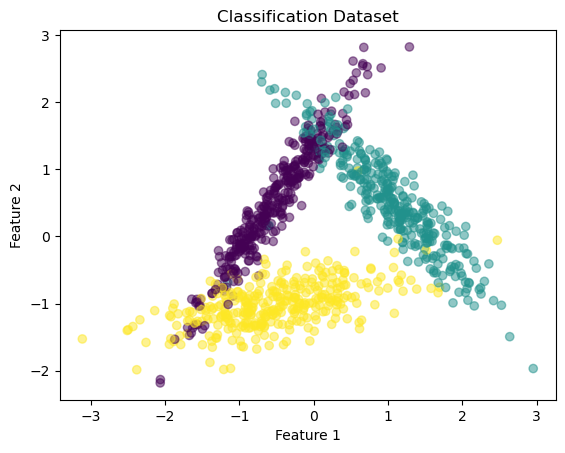

In [7]:
plt.scatter(Xc[0, :], Xc[1,:], c=np.argmax(Yc, axis=0), alpha=0.5)
plt.title("Classification Dataset")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.show()

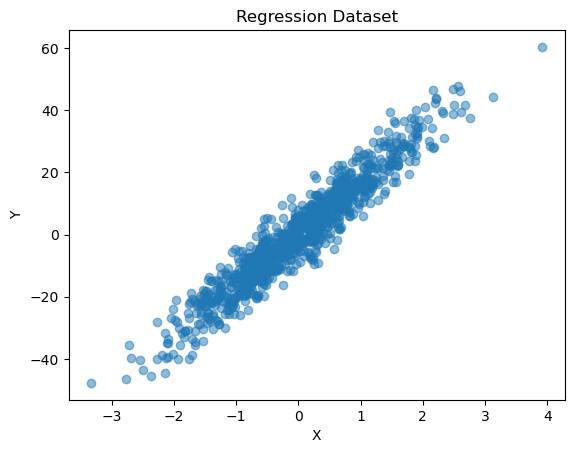

In [8]:
plt.scatter(Xr[0, :], Yr[0,:], alpha=0.5)
plt.title("Regression Dataset")
plt.xlabel("X")
plt.ylabel("Y")
plt.show()

# Running Regression and Classification

In [9]:
# lr = 0.1. decay_rate = 0.3
reg_adam = regression_classifier_nn(layers = [1, 10, 1], training_iterations = 50, learning_rate =0.1, initialization='he', dropout=True, drop_prob=0.05, optimizer='adam', num_batches=10, decay_rate=0.3, decay_step=10)
reg_gd_m = regression_classifier_nn(layers = [1, 10, 1], training_iterations = 50, learning_rate =0.1, initialization='he', dropout=True, drop_prob=0.05, optimizer='gd_m',num_batches=10, decay_rate=0.3, decay_step=10)
reg_gd = regression_classifier_nn(layers = [1, 10, 1], training_iterations = 50, learning_rate =0.1, initialization='he', dropout=True, drop_prob=0.05, optimizer='gd',num_batches=10, decay_rate=0.3, decay_step=10)

In [10]:
_, cost_hist_reg_adam = reg_adam.train(Xr, Yr)
_, cost_hist_reg_gd_m = reg_gd_m.train(Xr, Yr)
_, cost_hist_reg_gd = reg_gd.train(Xr, Yr)

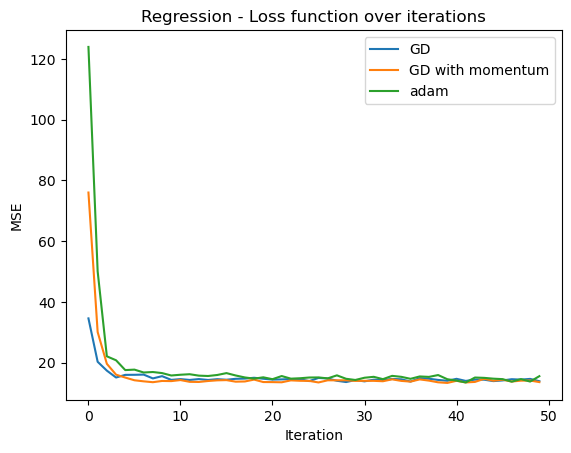

In [11]:
plt.plot(cost_hist_reg_gd, label="GD")
plt.plot(cost_hist_reg_gd_m, label="GD with momentum")
plt.plot(cost_hist_reg_adam, label="adam")
plt.title("Regression - Loss function over iterations")
plt.ylabel("MSE")
plt.xlabel("Iteration")
plt.legend()
plt.show()

In [12]:
clf_adam = multiclass_classifier_nn(layers = [2, 5, 3],  training_iterations = 200, learning_rate = 0.1, initialization='xavier', dropout=True, drop_prob=0.1, optimizer='adam', num_batches=10, decay_rate=0.05, decay_step=10)
clf_gd_m = multiclass_classifier_nn(layers = [2, 5, 3],  training_iterations = 200, learning_rate = 0.1, initialization='xavier', dropout=True, drop_prob=0.1, optimizer='gd_m', num_batches=10, decay_rate=0.05, decay_step=10)
clf_gd = multiclass_classifier_nn(layers = [2, 5, 3],  training_iterations = 200, learning_rate = 0.1, initialization='xavier', dropout=True, drop_prob=0.1, optimizer='gd', num_batches=10, decay_rate=0.05, decay_step=10)

In [13]:
_, cost_hist_clf_adam = clf_adam.train(Xc, Yc)
_, cost_hist_clf_gd_m = clf_gd_m.train(Xc, Yc)
_, cost_hist_clf_gd = clf_gd.train(Xc, Yc)

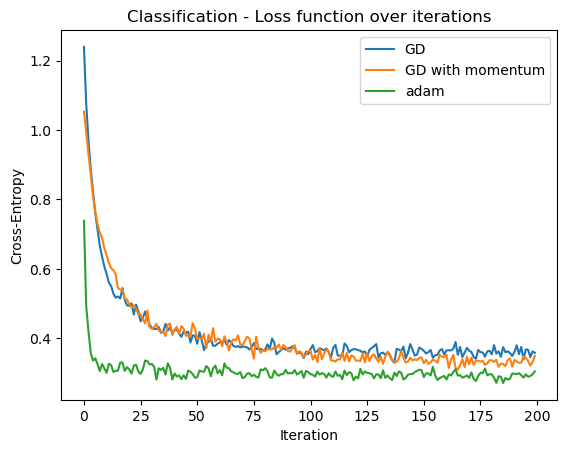

In [14]:
plt.plot(cost_hist_clf_gd, label="GD")
plt.plot(cost_hist_clf_gd_m, label="GD with momentum")
plt.plot(cost_hist_clf_adam, label="adam")
plt.title("Classification - Loss function over iterations")
plt.ylabel("Cross-Entropy")
plt.xlabel("Iteration")
plt.legend()
plt.show()

Note that setting `dropout=True` causes the cost function to become noisy. This is reasonable since _technically_ at each iteration a different model is being trained, so the costs need not decrease smoothly.

Note also that in general the `adam` optimizer seems to do just as well, if not better, than the other two optimizers (Gradient descent, `gd`, and Gradient Descent with momentum, `gd_m`)

# Plotting Decision Regions and Regression Line

In [15]:
def plot_regression_line(X, Y, f, resolution=0.01):
    
    # X must have shape (1, m)
    # Y must have shape (1, m)
    m = X.shape[1]
    assert X.shape[0] == 1
    assert Y.shape[0] == 1
    assert Y.shape[1] == m
    
    X = X.flatten() 
    Y = Y.flatten()
    
    x_min, x_max = X.min() - 1, X.max() + 1
    
    x_values = np.arange(x_min, x_max, resolution)
    y_values = f(x_values.reshape(1, -1)).flatten()
    
    plt.scatter(X, Y, color='blue', edgecolor='k', s=50, alpha=0.6, label="Data Points")
    plt.plot(x_values, y_values, color='red', linewidth=2, label="Regression Line")
    
    # Set plot limits
    plt.xlim(x_min, x_max)
    plt.ylim(Y.min() - 1, Y.max() + 1)
    
    plt.title("Regression Line and Data Points")
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.legend()
    plt.show()



def plot_decision_boundaries(X, Y, f, resolution=0.01):
    
    # X must have shape (n_features, m)
    # Y must have shape (n_classes, m)
    m = X.shape[1]
    assert Y.shape[1] == m
    
    x_min, x_max = X[0, :].min() - 1, X[0, :].max() + 1
    y_min, y_max = X[1, :].min() - 1, X[1, :].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, resolution),
                         np.arange(y_min, y_max, resolution))
    grid_points = np.c_[xx.ravel(), yy.ravel()].T
    Yhat = f(grid_points) 
    
    Z = np.argmax(Yhat, axis=0)
    Z = Z.reshape(xx.shape)
    
    # Plot the decision boundary
    colors = ['lightblue', 'lightgreen', 'lightcoral']
    cmap_background = ListedColormap(colors)
    plt.contourf(xx, yy, Z, cmap=cmap_background)
    
    
    
    # Plot the points, colored by their true class
    cmap_points = ListedColormap(['blue', 'green', 'red'])
    plt.scatter(X[0, :], X[1, :], c=np.argmax(Y, axis=0), cmap=cmap_points, edgecolor='k', s=50, alpha=0.1)
    
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.title("Decision Boundaries and Data Points")
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.show()



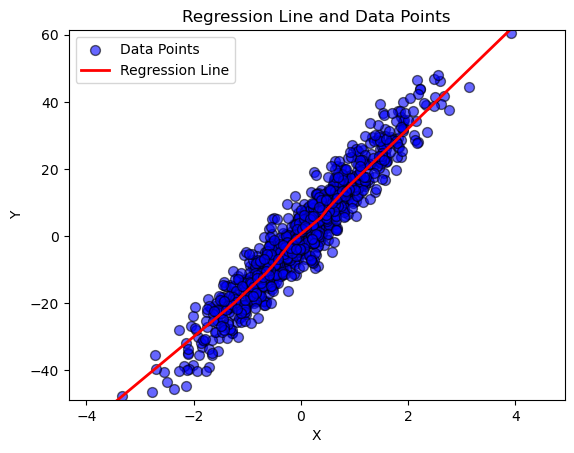

In [16]:
plot_regression_line(Xr, Yr, f=reg_adam.predict)

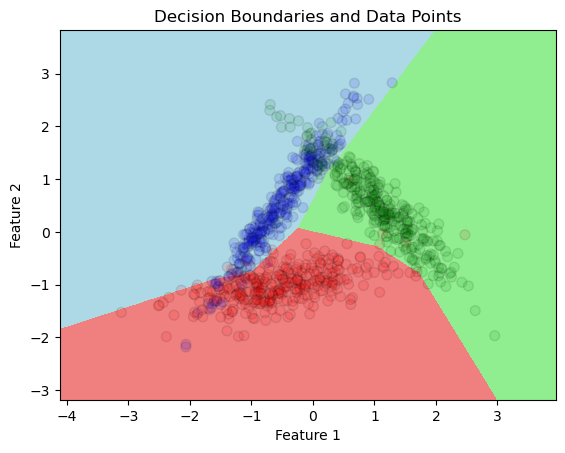

In [17]:
plot_decision_boundaries(Xc, Yc, clf_adam.predict_proba)

# Closing Remarks

As before, we have not focused on the quantitative performance of this model. Qualitatively, from the loss function plots, we can verify that training is indeed procceding as expected, noisy due to dropout and mini-batches, and we can conclude that `adam` is a good optimizer choice. 